In [37]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [38]:
npy_dir = "data/lstm_data/train/"
labels = [str(s) for s in [4, 6, 8, 10, 12]]

#load npy files into array
npy_files = {label: np.load(npy_dir + f"{label}_data.npy") for label in labels}

In [39]:
# Step 1: Load and Prepare the Data
npy_dir = "data/lstm_data/train/"
labels = [str(s) for s in [4, 6, 8, 10, 12]]

# Load .npy files into arrays
npy_data = {label: np.load(npy_dir + f"{label}_data.npy") for label in labels}

#Show length of each label
for key, value in npy_data.items():
    print(f"Length of label {key}: {len(value)}")

Length of label 4: 274
Length of label 6: 814
Length of label 8: 350
Length of label 10: 172
Length of label 12: 230


In [46]:
# Step 1: Load and Prepare the Data
npy_dir = "data/lstm_data/train/"
labels = [str(s) for s in [4, 6, 8, 10, 12]]

# Load .npy files into arrays
data = []
target = []
for label in labels:
    samples = np.load(npy_dir + f"{label}_data.npy")
    data.append(samples)
    target.extend([label] * len(samples))

# Combine data and labels
data = np.vstack(data)  # Stack all samples into a single 2D array
target = np.array(target)

# Relabel the data for binary classification (6 vs non-6)
binary_target = np.array([1 if t == '6' else 0 for t in target])

# Split into training and validation sets
sorted_indices = np.argsort(binary_target)  # Sort by class labels
data_sorted = data[sorted_indices]
target_sorted = binary_target[sorted_indices]

# Split the data sequentially
split_ratio = 0.8  # Use the last 80% for training
train_indices = []
val_indices = []

# Process each class separately
for label in np.unique(target_sorted):
    class_indices = np.where(target_sorted == label)[0]  # Indices of this class
    split_point = int(len(class_indices) * split_ratio)  # Split point for this class
    train_indices.extend(class_indices[:split_point])    # First X% for validation
    val_indices.extend(class_indices[split_point:])      # Last (1-X)% for training

# Step 3: Create train and validation sets
X_train = data_sorted[train_indices]
y_train = target_sorted[train_indices]
X_val = data_sorted[val_indices]
y_val = target_sorted[val_indices]
# Normalize the data
X_train = X_train / np.max(np.abs(X_train), axis=1, keepdims=True)
X_val = X_val / np.max(np.abs(X_val), axis=1, keepdims=True)


In [47]:
#Find out the data balance
unique, counts = np.unique(y_train, return_counts=True)
print("Training data distribution:", dict(zip(unique, counts)))

Training data distribution: {0: 820, 1: 651}


In [54]:


# Step 2: Define the LSTM Model
model = Sequential([
    LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.4),
    LSTM(128),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 40, 256)           396288    
                                                                 
 dropout_20 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_21 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 593,537
Trainable params: 593,537
Non-trainable params: 0
_________________________________________________________________


In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    #class_weight=class_weights,
    #callbacks=[early_stopping],
    verbose=1
)



Epoch 1/200
46/46 [==============================] - 14s 179ms/step - loss: 0.6902 - accuracy: 0.5398 - val_loss: 0.6832 - val_accuracy: 0.5583
Epoch 2/200
46/46 [==============================] - 6s 129ms/step - loss: 0.6882 - accuracy: 0.5561 - val_loss: 0.6836 - val_accuracy: 0.5664
Epoch 3/200
46/46 [==============================] - 6s 121ms/step - loss: 0.6862 - accuracy: 0.5561 - val_loss: 0.6806 - val_accuracy: 0.5583
Epoch 4/200
46/46 [==============================] - 6s 125ms/step - loss: 0.6832 - accuracy: 0.5663 - val_loss: 0.6416 - val_accuracy: 0.6504
Epoch 5/200
46/46 [==============================] - 6s 134ms/step - loss: 0.6831 - accuracy: 0.5615 - val_loss: 0.6708 - val_accuracy: 0.5393
Epoch 6/200
46/46 [==============================] - 6s 136ms/step - loss: 0.6717 - accuracy: 0.5867 - val_loss: 0.6539 - val_accuracy: 0.6179
Epoch 7/200
46/46 [==============================] - 7s 145ms/step - loss: 0.6794 - accuracy: 0.5806 - val_loss: 0.6514 - val_accuracy: 0.607

Validation Loss: 3.4366, Validation Accuracy: 0.5989
12/12 [==============================] - 1s 61ms/step


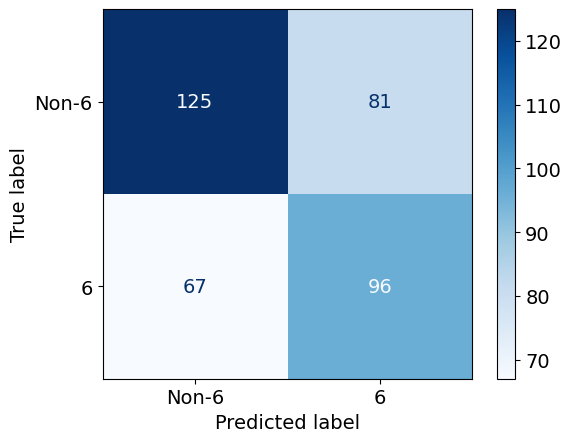

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 5: Evaluate the Model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Step 6: Make Predictions
predictions = model.predict(X_val)
predicted_classes = (predictions > 0.5).astype(int)

# Display the confusion matrix
cm = confusion_matrix(y_val, predicted_classes)

#Increase text size
plt.rcParams['font.size'] = 14

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-6', '6'])
disp.plot(cmap='Blues')
plt.show()

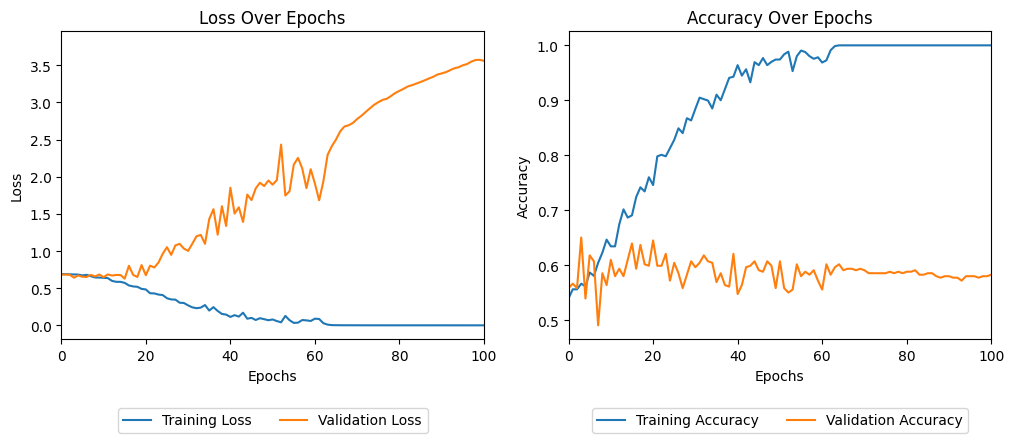

In [ ]:
#Plot training history from "history" object
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
#X axis limits
plt.xlim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Loss')
#Put legend below plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlim([0, 100]) 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

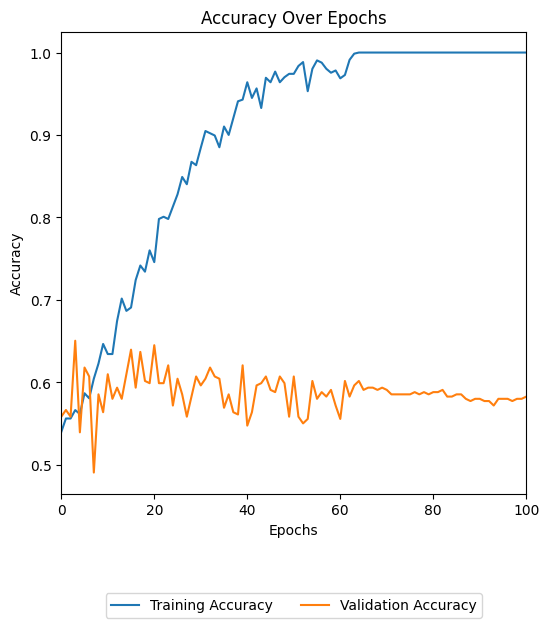

In [60]:
#Plot training history from "history" object
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlim([0, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()